In [1]:
library(data.table)
library(ggplot2)
library(tidyverse)
library(dplyr)
library(cowplot)
library(sp)
#library(raster)
library(pracma)  # for polygon rea

options(repr.matrix.max.cols=150)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::sec

In [2]:
# Functions

parsePointsString = function(points_string) {
    # Parse points string to data.frame of pixel coordinates
    points = strsplit(points_string, " ")[[1]]
    points = data.frame(do.call(rbind, strsplit(points, ",")), stringsAsFactors=FALSE)
    colnames(points) = c("x", "y")

    # Interpret characters as floating points
    points$x = as.numeric(points$x)
    points$y = as.numeric(points$y)
    
    return(points)
}

# Example usage
#points = parsePointsString(regions$Points[2])
#idx = point.in.polygon(cells$x, cells$y, points$x * umPerPix, points$y * umPerPix)

# Input

In [3]:
# Pixel dimensions
umPerPix = 0.4983437248734626  # from OMERO metadata

In [4]:
# List OMERO annotation output files. Manually exported from OMERO.iviewer.
# Contains MUC6+ gland annotations and matching control glands.
roi_files = list.files(path="data/omero_regions", pattern=".csv", full.names=TRUE)
#roi_files

In [5]:
# Load regions for all images
regions = lapply(roi_files, fread)
regions = rbindlist(regions)

In [6]:
#regions

In [7]:
# Exclude non-annotated regions
exclude_regions = c("CD4 T cell MUC6 interaction", "CD4 T cell-MUC6 interaction", "T cell MUC6 interaction", "MUC6+")  # names that are not gland annotations

regions = regions[regions$Text != "" & ! regions$Text %in% exclude_regions, ]

In [8]:
head(regions)

image_id
1 42598   
2 42598   
3 42598   
4 42598   
5 42598   
6 42598   
  image_name                                                                                
1 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff [resolution #1]
2 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff [resolution #1]
3 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff [resolution #1]
4 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff [resolution #1]
5 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff [resolution #1]
6 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff [resolution #1]
  roi_id shape_id type     z  t  channel area (µm²) length (µm) points min max
1 36302  40148    polyline NA NA NA      NA         487.278     NA     NA  NA 
2 36303  40149    polyline NA NA NA      NA         378.584     NA     NA  NA 
3 36304  40150    polyline NA NA NA      NA         335.924     NA     NA  NA 
4 36305  40151    polyline NA NA NA      NA         214.472     NA     NA  NA 
5 36306  40152    polyline NA NA NA      NA         284.899     NA     NA  NA 
6 36307  40153    polyline NA NA NA      NA         198.163     NA     NA  NA 
  sum mean std_dev Text            
1 NA  NA   NA      MUC6_region2a   
2 NA  NA   NA      control_region2a
3 NA  NA   NA      control_region2b
4 NA  NA   NA      MUC6_region2b   
5 NA  NA   NA      MUC6_region2c   
6 NA  NA   NA      MUC6_region2d   
  Points                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
1 13517.75,12628.27 13518.09,12593.15 13526.64,12552.45 13536.16,12531.74 13588.15,12491.79 13637.78,12447.95 13656.83,12436.33 13682.61,12426.86 13698.84,12424.56 13751.59,12424.03 13767.00,12426.74 13784.86,12433.51 13801.83,12445.99 13818.19,12465.10 13830.50,12488.42 13833.82,12504.70 13833.82,12564.82 13831.11,12575.86 13798.10,12630.20 13784.80,12646.67 13752.53,12665.02 13719.76,12666.90 13681.60,12658.46 13657.78,12657.98 13643.40,12665.05 13617.84,12687.90 13601.69,12689.37 13584.01,12685.16 13546.56,12669.41 13529.21,12654.81 13517.25,12619.02 13515.39,12590.28
2 13347.24,12832.49 13356.78,12809.74 13409.82,12741.44 13446.01,12706.17 13477.79,12689.65 13517.52,12687.20 13538.55,12694.68 13586.31,12727.19 13601.97,12746.05 13609.80,12762.81 13612.42,12813.71 13608.57,12834.23 13603.04,12845.59 13591.54,12856.29 13554.65,12878.24 13517.79,12890.34 13469.52,12894.55 13399.62,12894.55 13381.65,12889.46 13366.33,12879.04 13351.46,12855.17 13351.96,12821.49                                                                                                                                                                                    
3 13603.80,12885.08 13582.48,12911.92 13578.93,12927.45 13579.82,12950.08 13587.97,12976.86 13598.75,12991.68 13615.61,13009.31 13640.56,13025.50 13661.19,13030.25 13712.81,13030.84 13745.53,13024.30 13789.85,13006.91 13813.95,12975.35 13818.40,12958.73 13818.30,12941.59 13811.55,12917.02 13782.92,12887.99 13753.84,12872.78 13687.16,12857.49 13644.36,12857.88 13624.90,12862.52 13610.92,12869.59 13592.73,12889.53                                                                                                                                                                  
4 13444.63,12319.57 13423.02,12293.68 13419.69,12285.51 13421.31,12252.32 13425.10,12242.69 13437.79,12229.42 13466.62,12222.87 13497.78,12220.99 13533.39,12

## Parse cells segemented by QuPath

In [9]:
cells = fread("data/qu_cells/measurements.tsv")

dim(cells)

[1] 21203    55

In [10]:
cells = as.data.frame(cells)

In [11]:
channel_names = c("DAPI", "TCRgd", "MUC6", "CD4", "CD3", "CD8", "AF", "Tmax")

In [12]:
# Add renamed columns for mean intensity by channel
for (k in 1:length(channel_names)) {
    col_name = paste0("Channel ", k, ": Mean")
    cells[, paste0(channel_names[k], "_mean")] = cells[, col_name] 
}


In [13]:
table(cells$Classification)  # not defined for all images


         Negative Positive 
    9690     7793     3720 

In [14]:
# Strip 'Image0' appendix to image name
cells$Image = sapply(strsplit(cells$Image, " - "), function(x) x[1])

In [15]:
# shorthand name for xy-coordinates
cells$x = cells[, 'Centroid X µm']
cells$y = cells[, 'Centroid Y µm']

In [16]:
head(cells)

Image                                                                     
1 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
2 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
3 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
4 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
5 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
6 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
  Object ID                            Object type Name Classification Parent 
1 9a7c33ba-1627-4aa3-bcfa-546f7a700169 Detection   NA   Positive       region1
2 06ad7a8f-73c7-4adf-bd96-185e9a3de483 Detection   NA   Negative       region1
3 da1aaab9-0798-4e96-b091-bbb69b4dc29c Detection   NA   Positive       region1
4 765b588b-f7de-4a71-b30f-77c5364ac919 Detection   NA   Negative       region1
5 0695ad35-44c7-4a3d-ba8c-160642511965 Detection   NA   Positive       region1
6 9153df63-1879-482e-b822-f29aed7ab700 Detection   NA   Negative       region1
  ROI     Centroid X µm Centroid Y µm Area µm^2 Length µm Circularity Solidity
1 Polygon 9433.0        7217.4        109.6227  40.5373   0.8383      0.9638  
2 Polygon 9552.7        7167.2         94.1054  49.7484   0.4778      0.8122  
3 Polygon 9546.5        7122.8         79.2516  39.2954   0.6450      0.8410  
4 Polygon 9314.1        7300.5         77.4888  38.9083   0.6432      0.9143  
5 Polygon 9349.5        7198.7         75.5048  35.3837   0.7578      0.9393  
6 Polygon 9194.6        7273.0         74.3682  39.0218   0.6137      0.9069  
  Max diameter µm Min diameter µm Channel 1: Mean Channel 1: Median
1 14.5764         10.2773          3.3341          0               
2 16.5613         10.4488         15.4430         11               
3 12.9887          9.8993         15.6208         13               
4 14.0128          8.3251         31.1424         26               
5 11.7131          9.0000         43.4760         48               
6 14.8389          7.0020         27.4733         16               
  Channel 1: Min Channel 1: Max Channel 1: Std.Dev. Channel 2: Mean
1 0               25             5.3989             0.4523         
2 0               52            12.9120             3.0622         
3 0               51            13.6277             5.0917         
4 0              108            25.3561             3.3625         
5 0               90            23.1861             6.5208         
6 0              104            28.7803             2.1767         
  Channel 2: Median Channel 2: Min Channel 2: Max Channel 2: Std.Dev.
1 0                 0               7             1.0424             
2 2                 0              18             3.0759             
3 4                 0              22             4.1421             
4 2                 0              19             3.8272             
5 6                 0              19             3.4973             
6 1                 0              14             3.1238             
  Channel 3: Mean Channel 3: Median Channel 3: Min Channel 3: Max
1  0.2045          0                0               39           
2  1.0881          0                0               10           
3  0.4434          0                0               11           
4  4.1748          2                0               40           
5 39.8690         26                6              182           
6  5.4567          5                0               19           
  Channel 3: Std.Dev. Channel 4: Mean Channel 4: Median Channel 4: Min
1  2.2627             7.3114          5                 0             
2  1.7823             1.3212          1                 0             
3  1.4106             1.3884          0                 0             
4  5.4975             1.7282          1                 0             
5 33.7234             0.1502          0                 0             
6  4.9426             7.300

In [17]:
table(cells$ROI)


  Polygon Rectangle 
    21201         2 

In [18]:
# Why is there rectable for some cells? Segmentation defined by QuPath.
cells[cells$ROI == "Rectangle", ]

Image                                                   
4822 RE_IBD_20221220_BU18-19563-4_BU18-19563-4_Scan1.ome.tiff
5434 RE_IBD_20221220_BU18-19563-4_BU18-19563-4_Scan1.ome.tiff
     Object ID                            Object type Name Classification
4822 aabd3e67-9d18-4869-a4ee-529dc963fabe Detection   NA                 
5434 a6c8834e-98c3-4ed2-9d68-415607404640 Detection   NA                 
     Parent  ROI       Centroid X µm Centroid Y µm Area µm^2 Length µm
4822 region2 Rectangle 14820.2       16835.1       5.5073    13.0059  
5434 region3 Rectangle 13188.7       13030.0       3.6954     7.9531  
     Circularity Solidity Max diameter µm Min diameter µm Channel 1: Mean
4822 0.4091      1        5.5923          1.0010          0.4444         
5434 0.7342      1        2.9021          1.4805          1.4444         
     Channel 1: Median Channel 1: Min Channel 1: Max Channel 1: Std.Dev.
4822 0.0               0              7              1.5389             
5434 0.5               0              6              1.9470             
     Channel 2: Mean Channel 2: Median Channel 2: Min Channel 2: Max
4822 0.25            0                 0              4             
5434 0.00            0                 0              0             
     Channel 2: Std.Dev. Channel 3: Mean Channel 3: Median Channel 3: Min
4822 0.77                0               0                 0             
5434 0.00                0               0                 0             
     Channel 3: Max Channel 3: Std.Dev. Channel 4: Mean Channel 4: Median
4822 0              0                   12.1389         12               
5434 0              0                   33.8333         35               
     Channel 4: Min Channel 4: Max Channel 4: Std.Dev. Channel 5: Mean
4822 1              29              8.0610             31.8333        
5434 8              56             13.7252              5.7222        
     Channel 5: Median Channel 5: Min Channel 5: Max Channel 5: Std.Dev.
4822 27.5              6              67             18.110             
5434  6.0              1              13              4.041             
     Channel 6: Mean Channel 6: Median Channel 6: Min Channel 6: Max
4822 5.0278          1.5               0              22            
5434 2.6667          3.0               0               7            
     Channel 6: Std.Dev. Channel 7: Mean Channel 7: Median Channel 7: Min
4822 6.6051              41.4444         40                15            
5434 2.1693              24.9444         25                12            
     Channel 7: Max Channel 7: Std.Dev. Channel 8: Mean Channel 8: Median
4822 74             15.7923             32.8333         27.5             
5434 34              6.4759             33.8333         35.0             
     Channel 8: Min Channel 8: Max Channel 8: Std.Dev. DAPI_mean TCRgd_mean
4822 9              67             16.9731             0.4444    0.25      
5434 8              56             13.7252             1.4444    0.00      
     MUC6_mean CD4_mean CD3_mean CD8_mean AF_mean Tmax_mean x       y      
4822 0         12.1389  31.8333  5.0278   41.4444 32.8333   14820.2 16835.1
5434 0         33.8333   5.7222  2.6667   24.9444 33.8333   13188.7 13030.0

## Plots of cells data

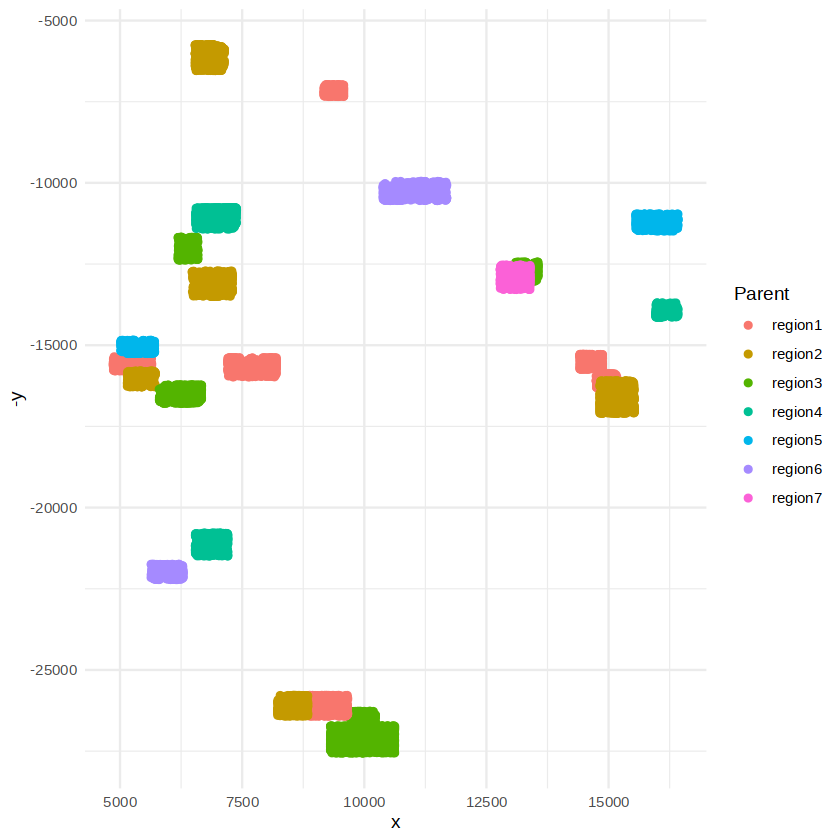

In [19]:

# Scatter plot of regions, for all images in same coordinate system
options(repr.plot.width = 7, repr.plot.height = 7)

ggplot(cells, aes(x=x, y=-y, col=Parent)) +
    geom_point() +
    #coord_fixed(ratio=1) +
    theme_minimal()

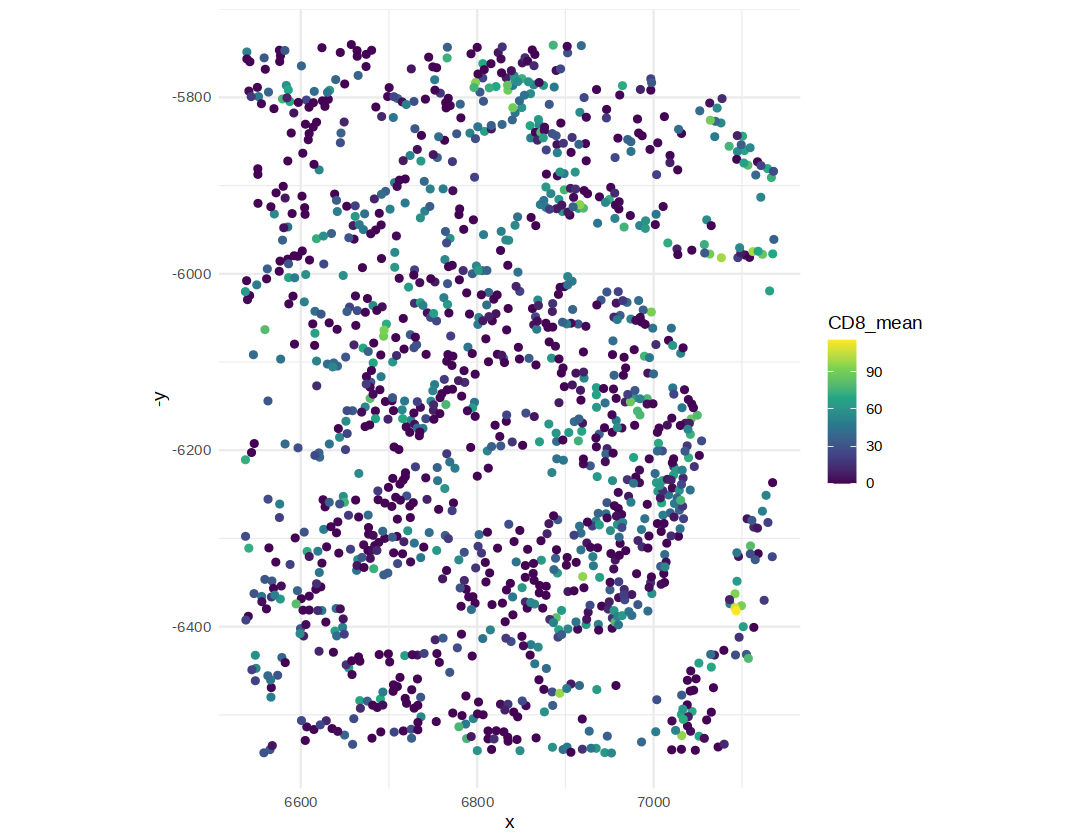

In [20]:
# Scatter plot of regions
options(repr.plot.width = 9, repr.plot.height = 7)

ggplot(cells %>% filter(Parent=="region2" & Image=="RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff"), aes(x=x, y=-y)) +
    geom_point(aes(col=CD8_mean)) +
    coord_fixed(ratio=1) +
    scale_color_viridis_c() +
    theme_minimal()

# Threshold cells

In [21]:
# Define channel name based on order, is transfered to data frames for short-hand reference
channel_names

[1] "DAPI"  "TCRgd" "MUC6"  "CD4"   "CD3"   "CD8"   "AF"    "Tmax"

In [22]:
# set channel-specific thresholds

thresholds = rep(10, length(channel_names))  # default threshold
thresholds[5] = 25  # CD3
thresholds[4] = 20  # CD4

names(thresholds) = channel_names  # for named retrieval

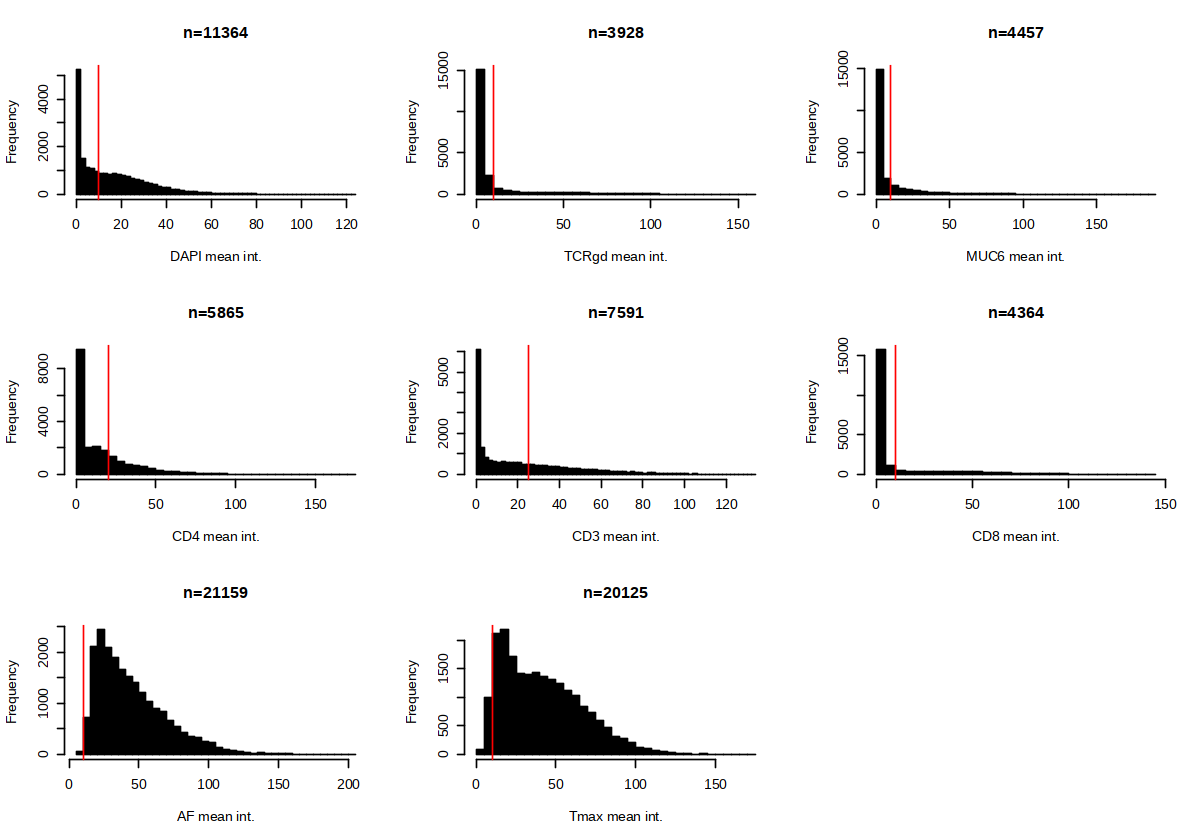

In [23]:
# Plot histograms and thresholds
options(repr.plot.width = 10, repr.plot.height = 7)

par(mfrow=c(3, 3))

for (k in 1:length(channel_names)) {
    col_name = paste0("Channel ", k, ": Mean")
    n_positive = sum(cells[, col_name] > thresholds[k])
    hist(cells[, col_name], breaks=50, xlab=paste0(channel_names[k], " mean int."), main=paste0("n=", n_positive), col="black")
    abline(v=thresholds[k], col="red")
}


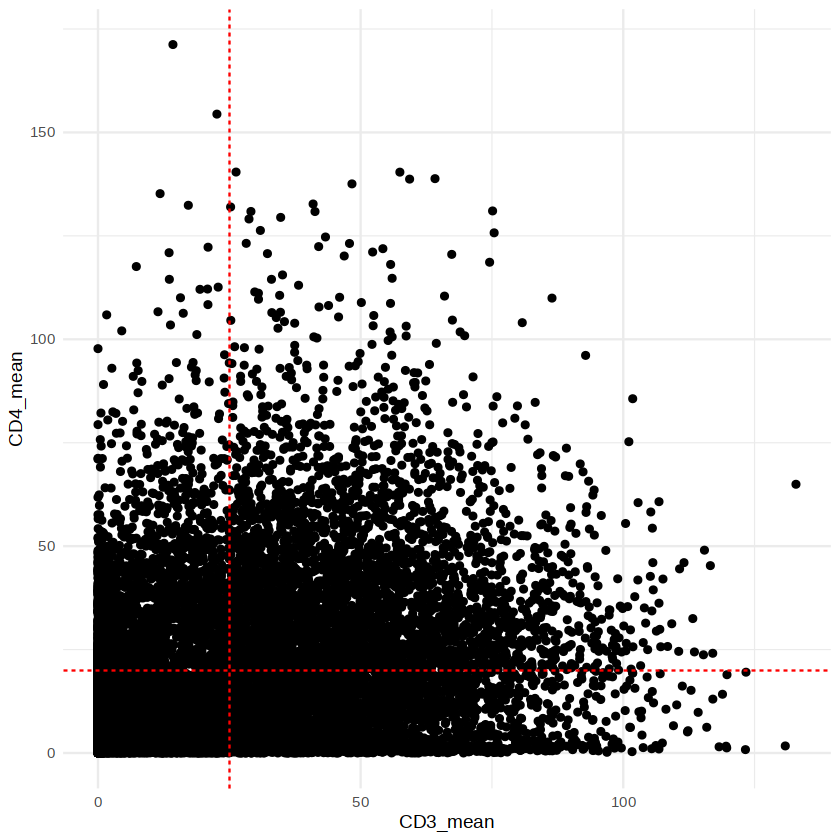

In [24]:
options(repr.plot.width = 7, repr.plot.height = 7)

ggplot(cells, aes(x=CD3_mean, y=CD4_mean)) +
    geom_point() +
    geom_hline(yintercept=thresholds['CD4'], col="red", linetype="dashed") +
    geom_vline(xintercept=thresholds['CD3'], col="red", linetype="dashed") +
    theme_minimal()

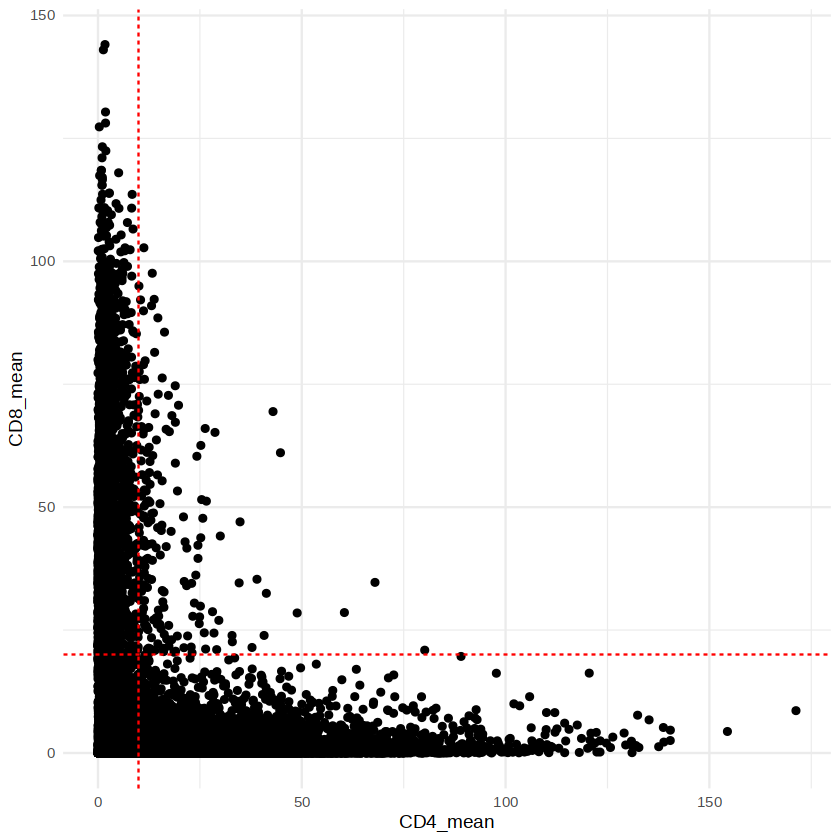

In [25]:
ggplot(cells, aes(x=CD4_mean, y=CD8_mean)) +
    geom_point() +
    geom_hline(yintercept=thresholds['CD4'], col="red", linetype="dashed") +
    geom_vline(xintercept=thresholds['CD8'], col="red", linetype="dashed") +
    theme_minimal()

# Filter cells based on size

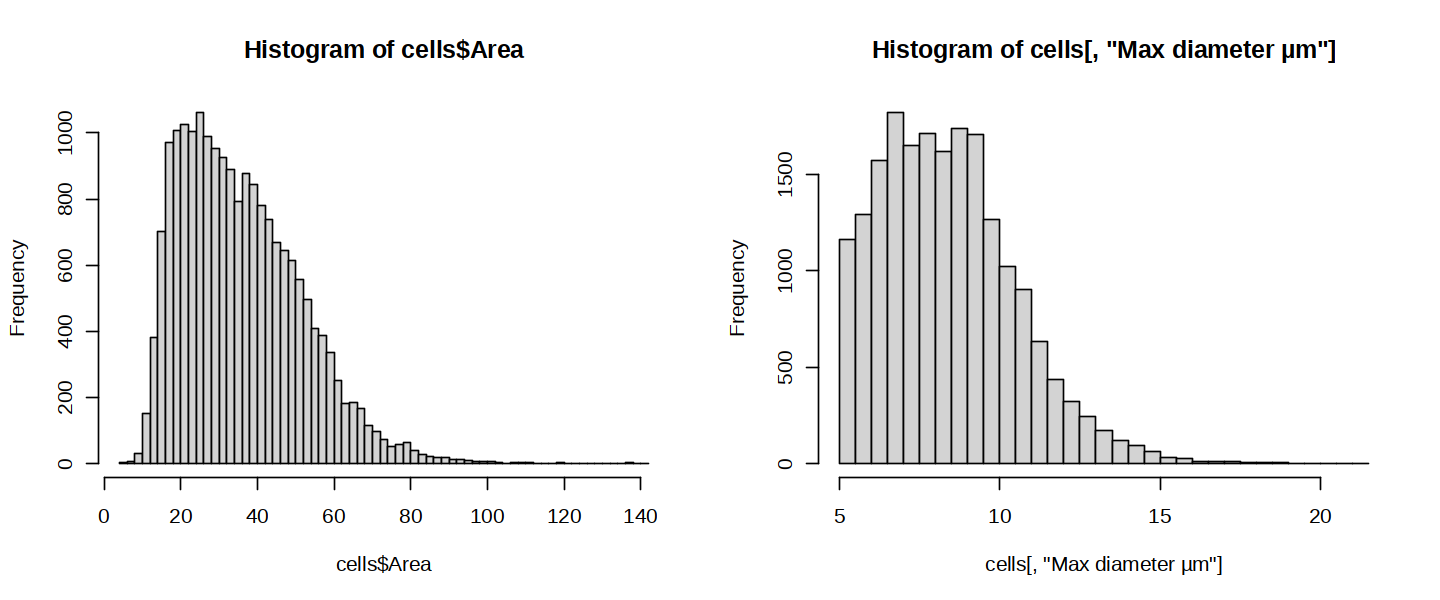

In [62]:
options(repr.plot.width = 12, repr.plot.height = 5)
par(mfrow=c(1, 2))
hist(cells$Area, breaks=50)
hist(cells[, "Max diameter µm"], breaks=50)

In [27]:
dim(cells)

[1] 21203    65

In [28]:
cells = cells[cells[, "Max diameter µm"] > 5, ]

In [29]:
dim(cells)

[1] 19671    65

# Cell type annotation

In [30]:
# Annotate cells by thresholding
cell_class = list()
cell_class[["CD3+ CD4- CD8- TCRgd-"]] = cells$CD3_mean > thresholds['CD3'] & cells$CD4_mean <= thresholds['CD4'] & cells$CD8_mean <= thresholds['CD8'] & cells$TCRgd_mean <= thresholds['TCRgd']
cell_class[["CD3+ CD4+ TCRgd- CD8-"]] = cells$CD3_mean > thresholds['CD3'] & cells$CD4_mean > thresholds['CD4']  & cells$TCRgd_mean <= thresholds['TCRgd'] & cells$CD8_mean <= thresholds['CD8']
cell_class[["CD3+ CD8+ TCRgd- CD4-"]] = cells$CD3_mean > thresholds['CD3'] & cells$CD8_mean > thresholds['CD8'] & cells$TCRgd_mean <= thresholds['TCRgd'] & cells$CD4_mean <= thresholds['CD4']
cell_class[["CD3+ TCRgd+ CD4- CD8-"]] = cells$CD3_mean > thresholds['CD3'] & cells$TCRgd_mean > thresholds['TCRgd'] & cells$CD4_mean <= thresholds['CD4'] & cells$CD8_mean <= thresholds['CD8'] 

In [31]:
# Count annotations to ascertain if unique
table(apply(as.data.frame(cell_class), 1, sum))


    0     1 
12480  7191 

In [32]:
# Transfer annotations to cells table
cells$annot = NA
for (label in names(cell_class)) {
    cells$annot[cell_class[[label]]] = label
}

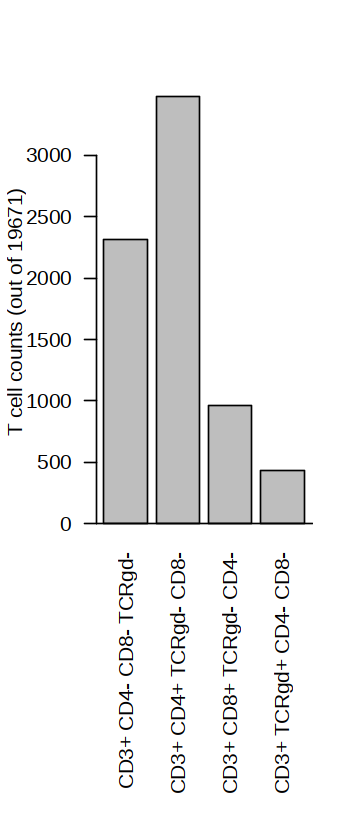

In [33]:
# Barplot of annotations
par(mar=c(13, 4, 4, 2))
options(repr.plot.width = 3, repr.plot.height = 7)

barplot(sapply(cell_class, sum), las=2, ylab=paste0("T cell counts (out of ", nrow(cells), ")"))
abline(h=0)

# Exploration of technical variability

In [120]:
colnames(cells)

[1] "Image"               "Object ID"           "Object type"        
 [4] "Name"                "Classification"      "Parent"             
 [7] "ROI"                 "Centroid X µm"       "Centroid Y µm"      
[10] "Area µm^2"           "Length µm"           "Circularity"        
[13] "Solidity"            "Max diameter µm"     "Min diameter µm"    
[16] "Channel 1: Mean"     "Channel 1: Median"   "Channel 1: Min"     
[19] "Channel 1: Max"      "Channel 1: Std.Dev." "Channel 2: Mean"    
[22] "Channel 2: Median"   "Channel 2: Min"      "Channel 2: Max"     
[25] "Channel 2: Std.Dev." "Channel 3: Mean"     "Channel 3: Median"  
[28] "Channel 3: Min"      "Channel 3: Max"      "Channel 3: Std.Dev."
[31] "Channel 4: Mean"     "Channel 4: Median"   "Channel 4: Min"     
[34] "Channel 4: Max"      "Channel 4: Std.Dev." "Channel 5: Mean"    
[37] "Channel 5: Median"   "Channel 5: Min"      "Channel 5: Max"     
[40] "Channel 5: Std.Dev." "Channel 6: Mean"     "Channel 6: Median"  
[43] "Channel 6: Min"      "Channel 6: Max"      "Channel 6: Std.Dev."
[46] "Channel 7: Mean"     "Channel 7: Median"   "Channel 7: Min"     
[49] "Channel 7: Max"      "Channel 7: Std.Dev." "Channel 8: Mean"    
[52] "Channel 8: Median"   "Channel 8: Min"      "Channel 8: Max"     
[55] "Channel 8: Std.Dev." "DAPI_mean"           "TCRgd_mean"         
[58] "MUC6_mean"           "CD4_mean"            "CD3_mean"           
[61] "CD8_mean"            "AF_mean"             "Tmax_mean"          
[64] "x"                   "y"                   "annot"              
[67] "gland_annot"         "image_gland_annot"

In [121]:
# Get mean matrix
#mat = cells[, c("TCRgd_mean", "CD4_mean", "CD3_mean", "CD8_mean", "Circularity", "Area µm^2")]
mat = cells[, c("DAPI_mean", "TCRgd_mean", "MUC6_mean", "CD4_mean", "CD3_mean", "CD8_mean", "AF_mean", "Circularity", "Solidity", "Area µm^2", "Max diameter µm")]

In [122]:
pca = prcomp(mat, scale=TRUE)

In [123]:
options(repr.plot.width = 7, repr.plot.height = 7)
tab = cbind(cells, pca$x)


In [124]:
head(tab)

Image                                                                     
1 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
2 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
3 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
4 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
5 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
6 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
  Object ID                            Object type Name Classification Parent 
1 9a7c33ba-1627-4aa3-bcfa-546f7a700169 Detection   NA   Positive       region1
2 06ad7a8f-73c7-4adf-bd96-185e9a3de483 Detection   NA   Negative       region1
3 da1aaab9-0798-4e96-b091-bbb69b4dc29c Detection   NA   Positive       region1
4 765b588b-f7de-4a71-b30f-77c5364ac919 Detection   NA   Negative       region1
5 0695ad35-44c7-4a3d-ba8c-160642511965 Detection   NA   Positive       region1
6 9153df63-1879-482e-b822-f29aed7ab700 Detection   NA   Negative       region1
  ROI     Centroid X µm Centroid Y µm Area µm^2 Length µm Circularity Solidity
1 Polygon 9433.0        7217.4        109.6227  40.5373   0.8383      0.9638  
2 Polygon 9552.7        7167.2         94.1054  49.7484   0.4778      0.8122  
3 Polygon 9546.5        7122.8         79.2516  39.2954   0.6450      0.8410  
4 Polygon 9314.1        7300.5         77.4888  38.9083   0.6432      0.9143  
5 Polygon 9349.5        7198.7         75.5048  35.3837   0.7578      0.9393  
6 Polygon 9194.6        7273.0         74.3682  39.0218   0.6137      0.9069  
  Max diameter µm Min diameter µm Channel 1: Mean Channel 1: Median
1 14.5764         10.2773          3.3341          0               
2 16.5613         10.4488         15.4430         11               
3 12.9887          9.8993         15.6208         13               
4 14.0128          8.3251         31.1424         26               
5 11.7131          9.0000         43.4760         48               
6 14.8389          7.0020         27.4733         16               
  Channel 1: Min Channel 1: Max Channel 1: Std.Dev. Channel 2: Mean
1 0               25             5.3989             0.4523         
2 0               52            12.9120             3.0622         
3 0               51            13.6277             5.0917         
4 0              108            25.3561             3.3625         
5 0               90            23.1861             6.5208         
6 0              104            28.7803             2.1767         
  Channel 2: Median Channel 2: Min Channel 2: Max Channel 2: Std.Dev.
1 0                 0               7             1.0424             
2 2                 0              18             3.0759             
3 4                 0              22             4.1421             
4 2                 0              19             3.8272             
5 6                 0              19             3.4973             
6 1                 0              14             3.1238             
  Channel 3: Mean Channel 3: Median Channel 3: Min Channel 3: Max
1  0.2045          0                0               39           
2  1.0881          0                0               10           
3  0.4434          0                0               11           
4  4.1748          2                0               40           
5 39.8690         26                6              182           
6  5.4567          5                0               19           
  Channel 3: Std.Dev. Channel 4: Mean Channel 4: Median Channel 4: Min
1  2.2627             7.3114          5                 0             
2  1.7823             1.3212          1                 0             
3  1.4106             1.3884          0                 0             
4  5.4975             1.7282          1                 0             
5 33.7234             0.1502          0                 0             
6  4.9426             7.300

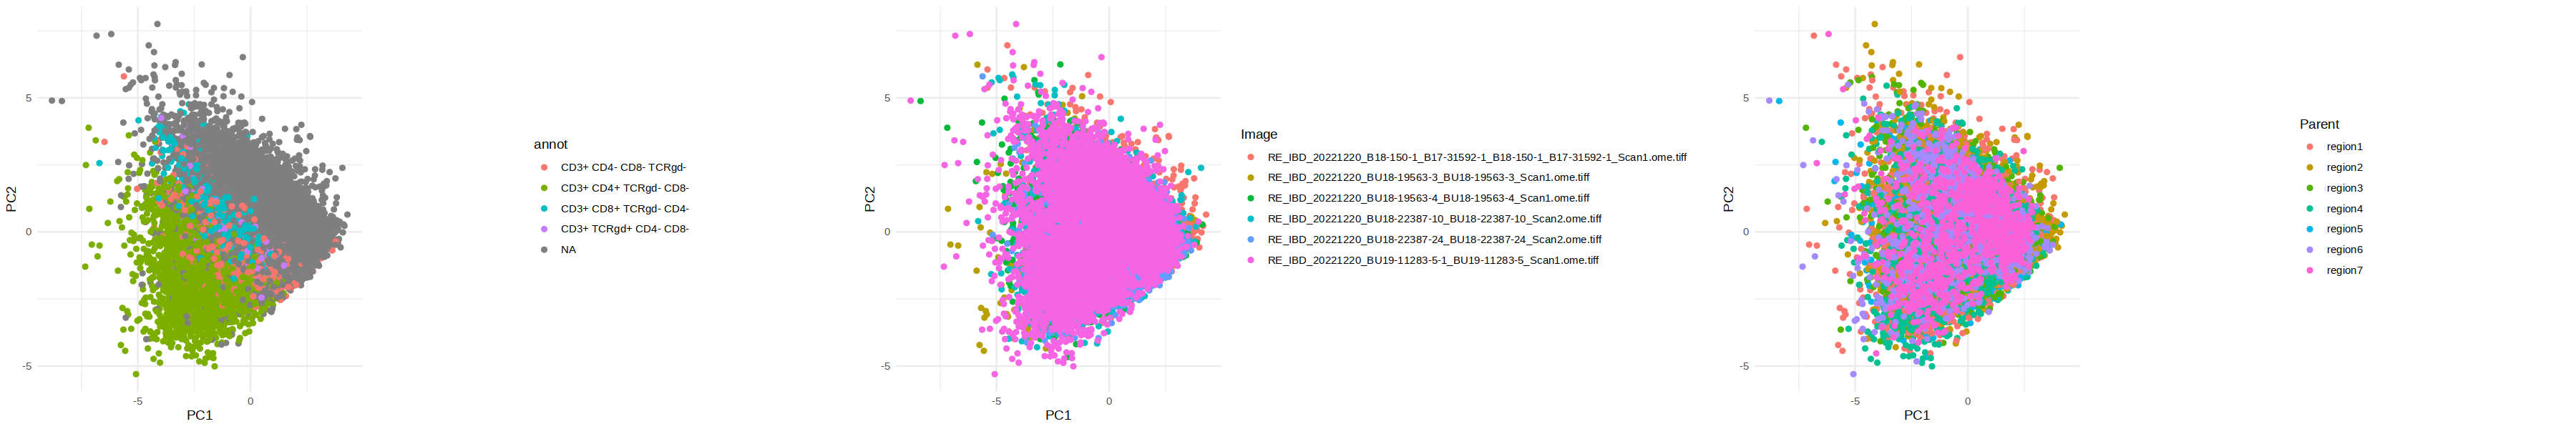

In [125]:
plts = lapply(c("annot", "Image", "Parent"), function(column) {
    ggplot(tab, aes(x=PC1, y=PC2, col=.data[[column]])) +
        geom_point() +
        theme_minimal()
})

options(repr.plot.width = 30, repr.plot.height = 5)
plot_grid(plotlist = plts, align = "vh", ncol=3)

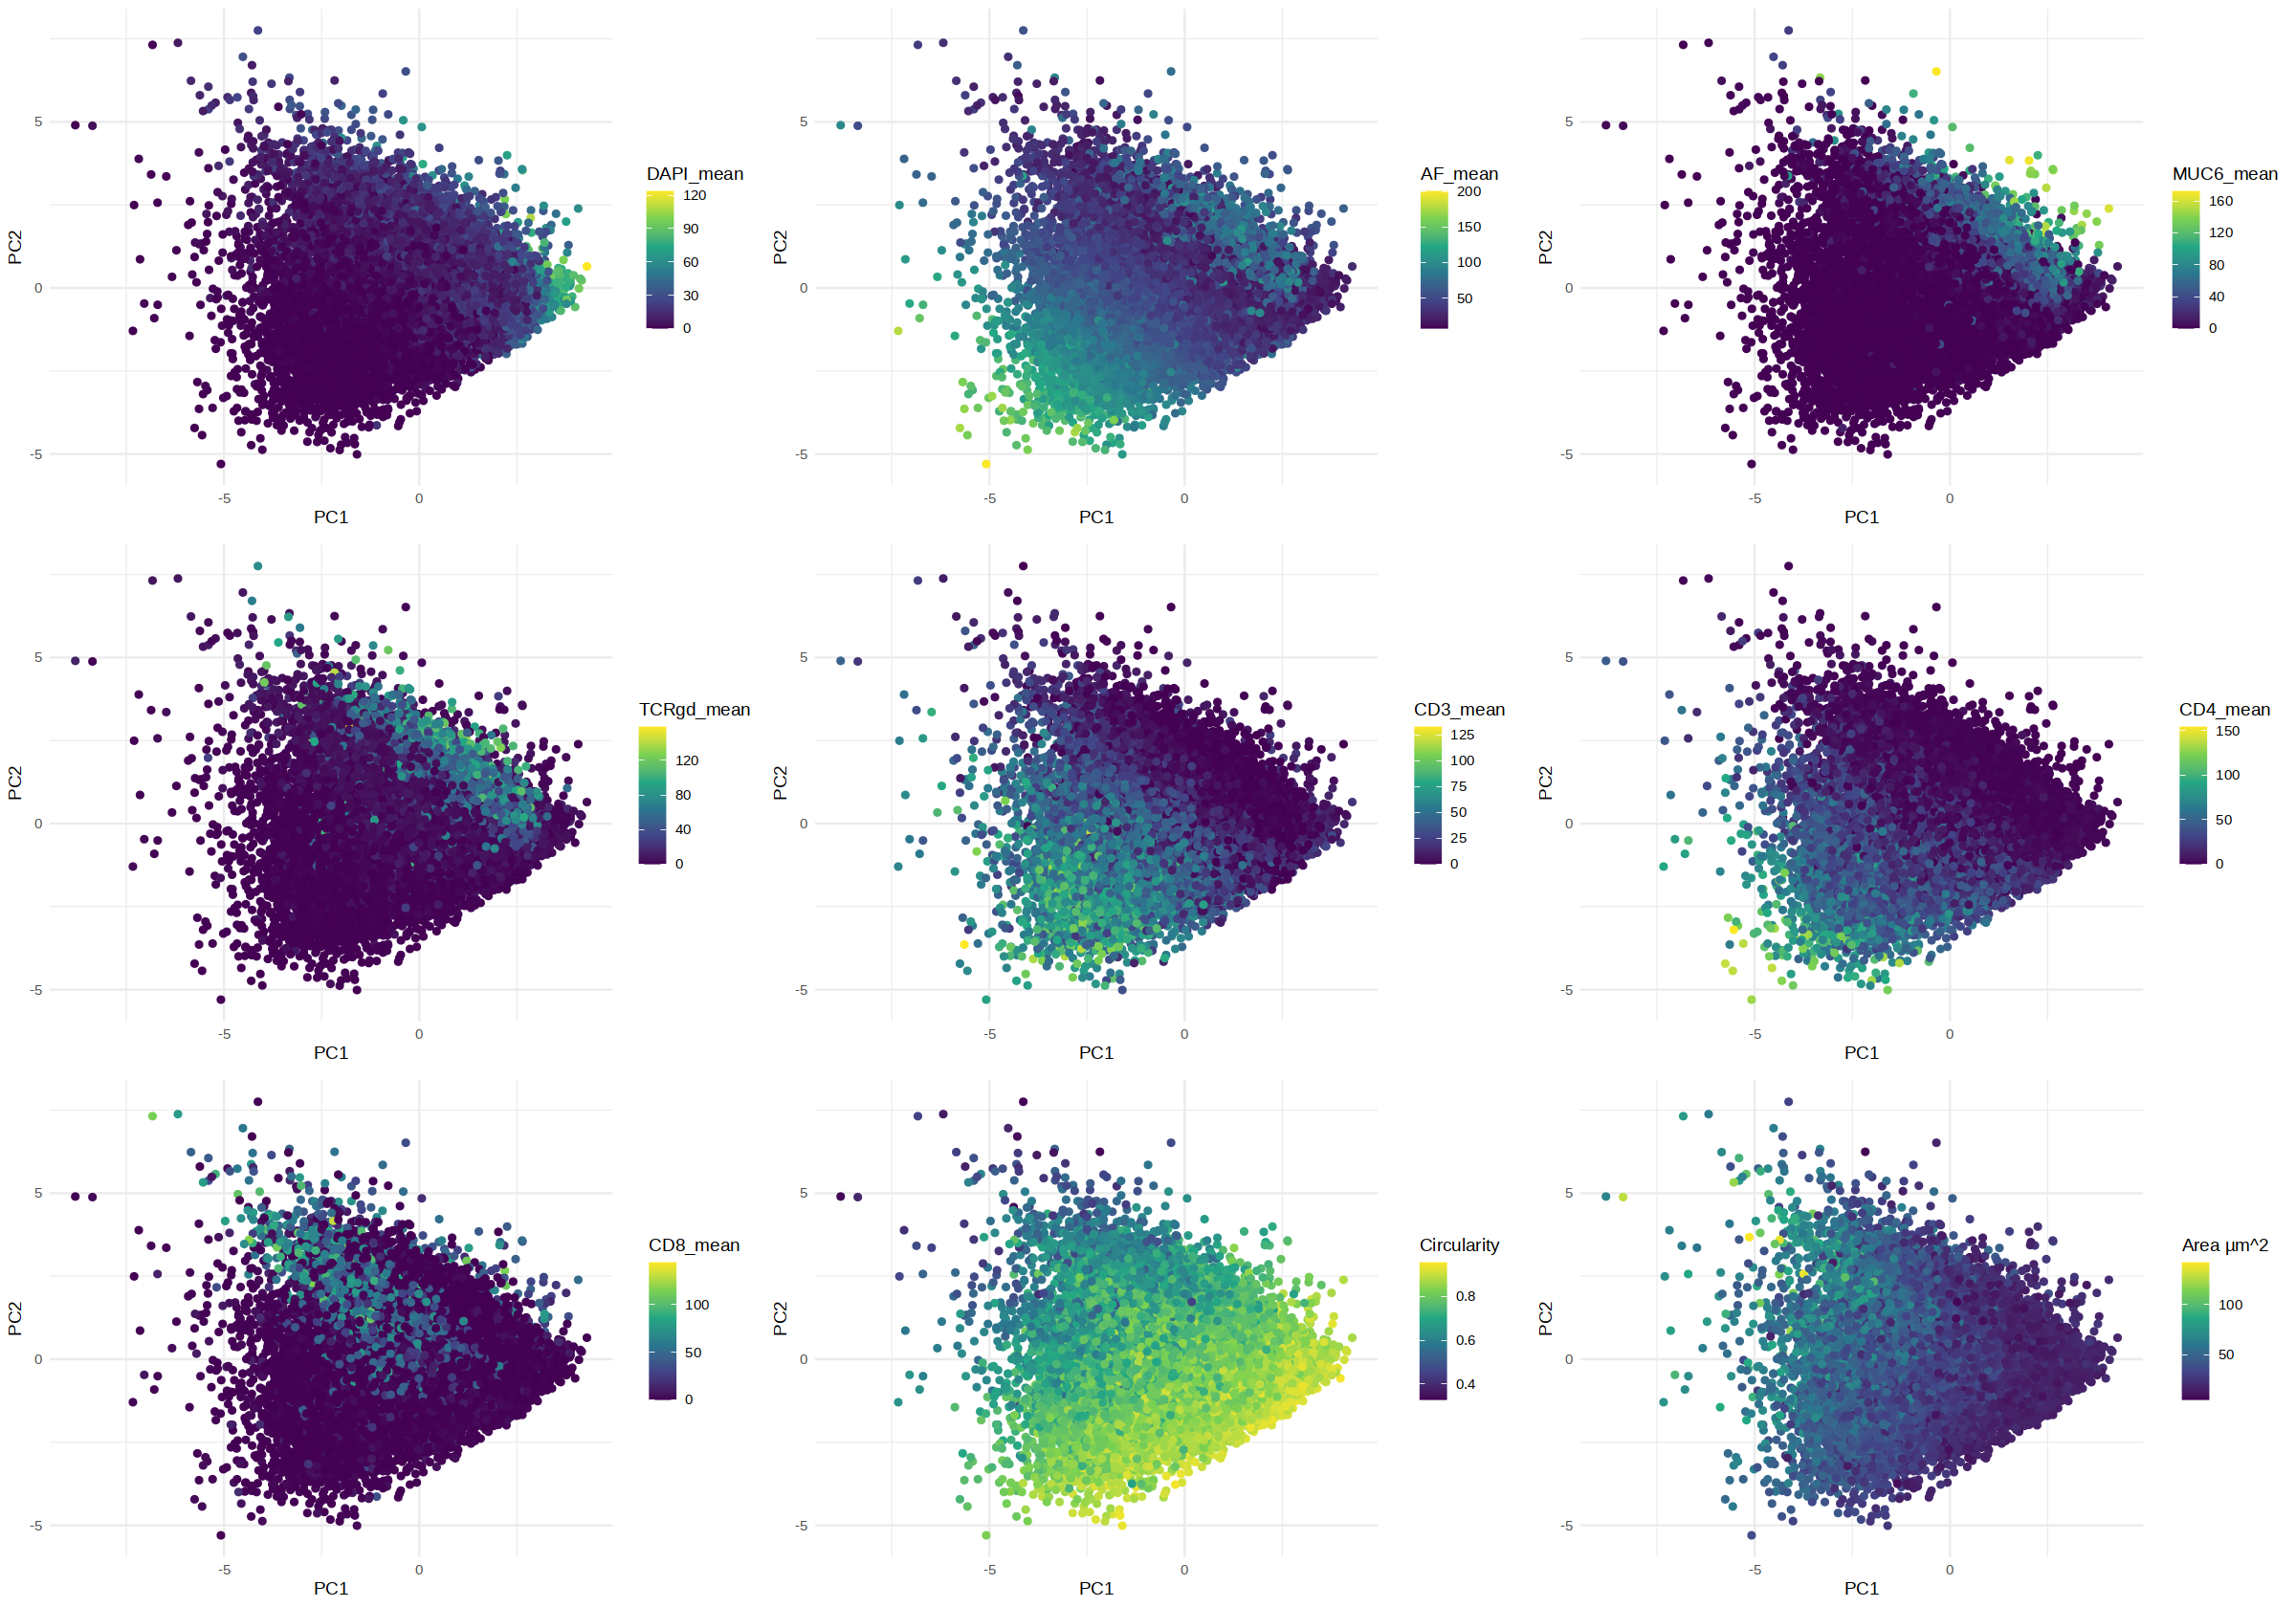

In [126]:
plts = lapply(c("DAPI_mean", "AF_mean", "MUC6_mean", "TCRgd_mean", "CD3_mean", "CD4_mean", "CD8_mean", "Circularity", "Area µm^2"), function(column) {
    ggplot(tab, aes(x=PC1, y=PC2, col=.data[[column]])) +
        geom_point() +
        scale_color_viridis_c() +
        theme_minimal()
})

options(repr.plot.width = 20, repr.plot.height = 14)
plot_grid(plotlist = plts, align = "vh")

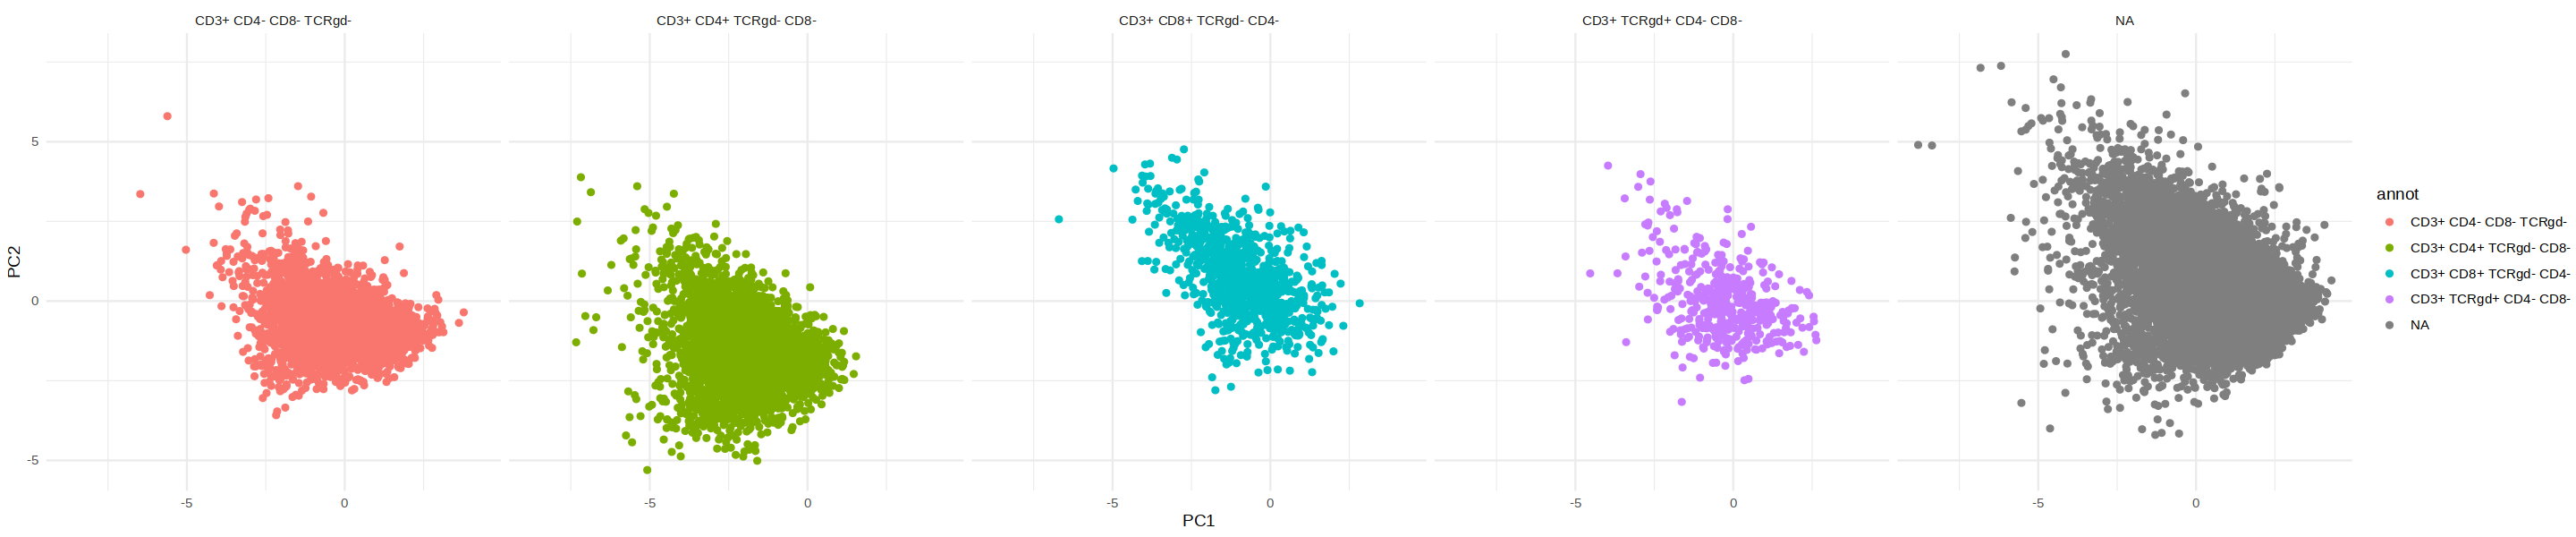

In [127]:
options(repr.plot.width = 24, repr.plot.height = 5)

ggplot(tab, aes(x=PC1, y=PC2, col=annot)) +
    facet_grid(. ~ annot) +
    geom_point() +
    theme_minimal()

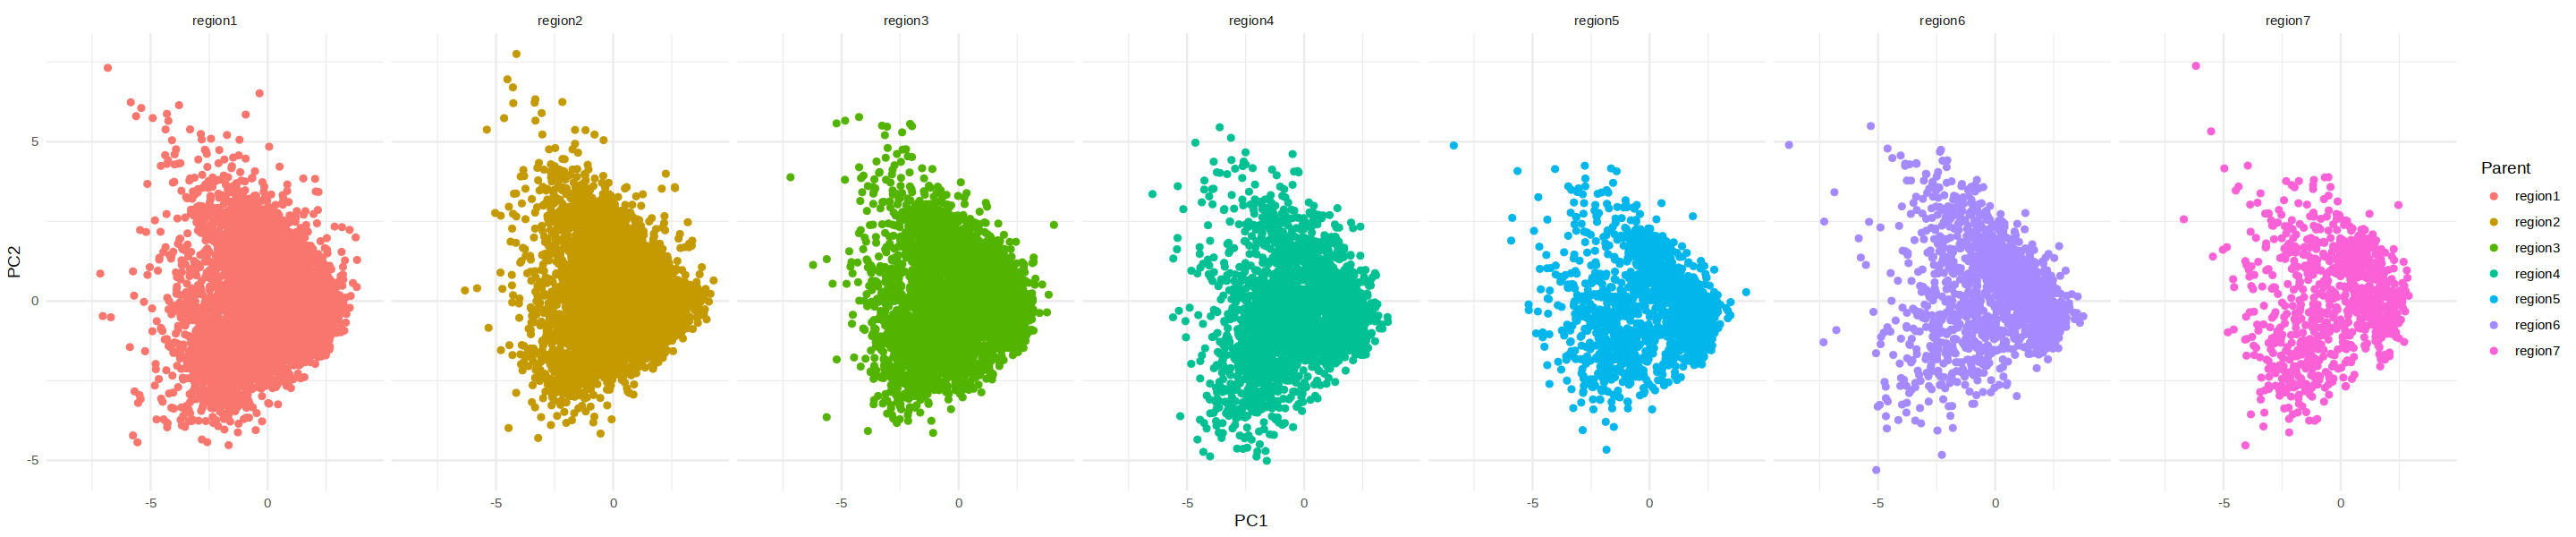

In [128]:
options(repr.plot.width = 24, repr.plot.height = 5)

ggplot(tab, aes(x=PC1, y=PC2, col=Parent)) +
    facet_grid(. ~ Parent) +
    geom_point() +
    theme_minimal()

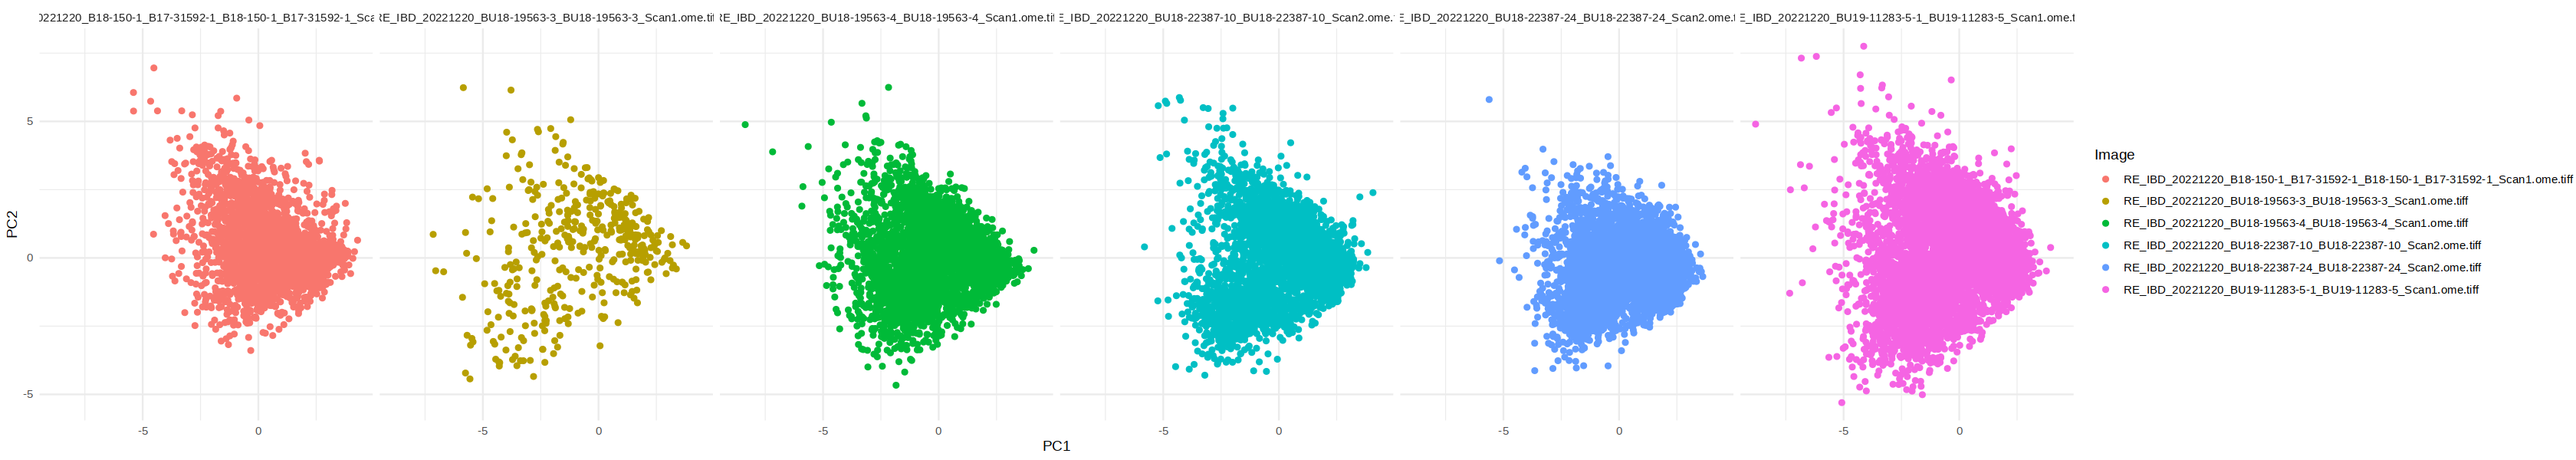

In [129]:
options(repr.plot.width = 28, repr.plot.height = 5)

ggplot(tab, aes(x=PC1, y=PC2, col=Image)) +
    facet_grid(. ~ Image) +
    geom_point() +
    theme_minimal()

In [44]:
#head(regions)

In [45]:
#head(cells)

# Map cell annotations to gland regions

In [46]:
cells$annot = factor(cells$annot)  # such that zeroes are included in cell type counts

In [47]:
# Map gland regions to cells by image
cell_map = lapply(1:nrow(regions), function(k) {
    
    # Get dataframe of polygon point set
    points = parsePointsString(regions$Points[k])
    
    # Get image name
    image = strsplit(regions$image_name[k], " \\[")[[1]][1]
    
    # Find cells with centroids in polygon
    idx = cells$Image == image
    idx = idx & point.in.polygon(cells$x, cells$y, points$x * umPerPix, points$y * umPerPix)  # converts from pixels to um units
    
    return(idx)
})

In [49]:
#head(regions)

In [50]:
# Transfer mapped annotation to cells data frame
cells$gland_annot = NA

for (k in 1:nrow(regions)) {
    idx = cell_map[[k]]
    cells$gland_annot[idx == 1] = regions$Text[k]
}

In [51]:
# Count cell type annotation per map region
cell_counts = lapply(cell_map, function(idx) {
    table(cells$annot[idx], useNA = "always")
})

# Combine counts to data frame
cell_counts = do.call(rbind, cell_counts)

colnames(cell_counts) = paste0("counts_", colnames(cell_counts))

# Add cell counts to regions data frame
regions = cbind(regions, cell_counts)

In [64]:
# Total T cell count in regions:
sum(cell_counts)

[1] 645

In [67]:
apply(cell_counts, 2, sum)

counts_CD3+ CD4- CD8- TCRgd- counts_CD3+ CD4+ TCRgd- CD8- 
                          73                           56 
counts_CD3+ CD8+ TCRgd- CD4- counts_CD3+ TCRgd+ CD4- CD8- 
                          60                           63 
                   counts_NA 
                         393

In [52]:
# Compute polygon area
regions$area_um2 = sapply(1:nrow(regions), function(k) {
    points = parsePointsString(regions$Points[k])

    polyarea(points$x * umPerPix, points$y * umPerPix)
})

regions$area_um2 = abs(regions$area_um2)  # clockwise/counterclockwise equivalent

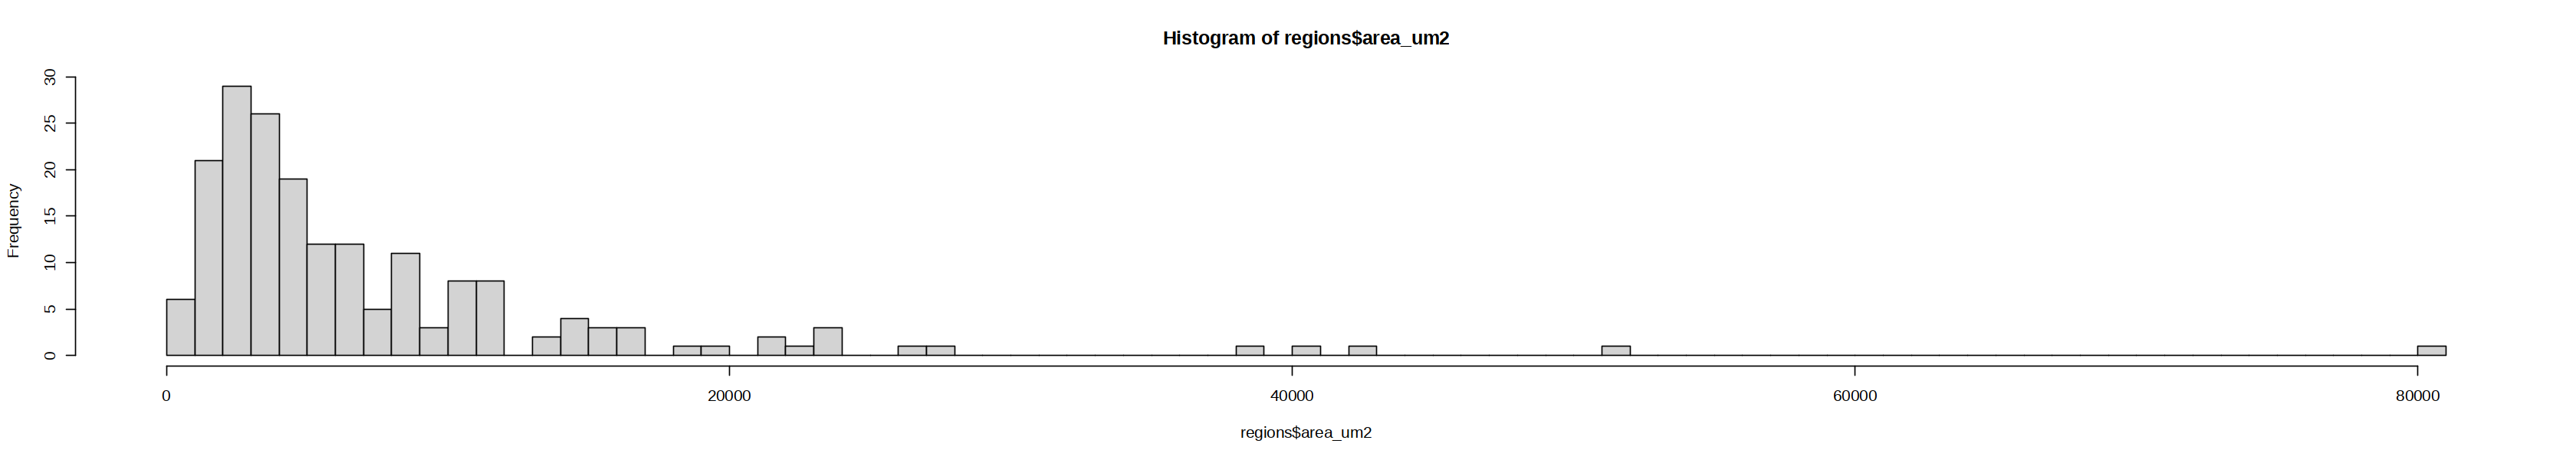

In [53]:
hist(regions$area_um2, breaks=100)

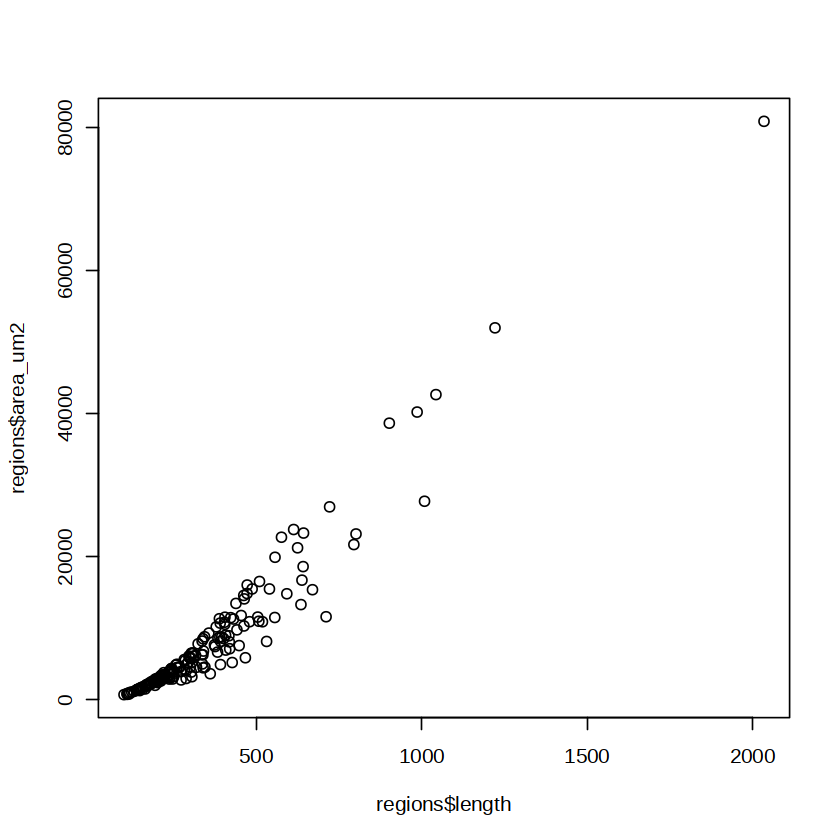

In [54]:
options(repr.plot.width = 7, repr.plot.height = 7)
plot(regions$length, regions$area_um2)  # sanity check on area calculation

In [55]:
#regions

In [56]:
# Make unique ID for gland annotation per image
cells$image_gland_annot = paste(cells$Image, cells$gland_annot, sep=":")

# Write output files

In [57]:
head(cells)

Image                                                                     
1 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
2 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
3 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
4 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
5 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
6 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff
  Object ID                            Object type Name Classification Parent 
1 9a7c33ba-1627-4aa3-bcfa-546f7a700169 Detection   NA   Positive       region1
2 06ad7a8f-73c7-4adf-bd96-185e9a3de483 Detection   NA   Negative       region1
3 da1aaab9-0798-4e96-b091-bbb69b4dc29c Detection   NA   Positive       region1
4 765b588b-f7de-4a71-b30f-77c5364ac919 Detection   NA   Negative       region1
5 0695ad35-44c7-4a3d-ba8c-160642511965 Detection   NA   Positive       region1
6 9153df63-1879-482e-b822-f29aed7ab700 Detection   NA   Negative       region1
  ROI     Centroid X µm Centroid Y µm Area µm^2 Length µm Circularity Solidity
1 Polygon 9433.0        7217.4        109.6227  40.5373   0.8383      0.9638  
2 Polygon 9552.7        7167.2         94.1054  49.7484   0.4778      0.8122  
3 Polygon 9546.5        7122.8         79.2516  39.2954   0.6450      0.8410  
4 Polygon 9314.1        7300.5         77.4888  38.9083   0.6432      0.9143  
5 Polygon 9349.5        7198.7         75.5048  35.3837   0.7578      0.9393  
6 Polygon 9194.6        7273.0         74.3682  39.0218   0.6137      0.9069  
  Max diameter µm Min diameter µm Channel 1: Mean Channel 1: Median
1 14.5764         10.2773          3.3341          0               
2 16.5613         10.4488         15.4430         11               
3 12.9887          9.8993         15.6208         13               
4 14.0128          8.3251         31.1424         26               
5 11.7131          9.0000         43.4760         48               
6 14.8389          7.0020         27.4733         16               
  Channel 1: Min Channel 1: Max Channel 1: Std.Dev. Channel 2: Mean
1 0               25             5.3989             0.4523         
2 0               52            12.9120             3.0622         
3 0               51            13.6277             5.0917         
4 0              108            25.3561             3.3625         
5 0               90            23.1861             6.5208         
6 0              104            28.7803             2.1767         
  Channel 2: Median Channel 2: Min Channel 2: Max Channel 2: Std.Dev.
1 0                 0               7             1.0424             
2 2                 0              18             3.0759             
3 4                 0              22             4.1421             
4 2                 0              19             3.8272             
5 6                 0              19             3.4973             
6 1                 0              14             3.1238             
  Channel 3: Mean Channel 3: Median Channel 3: Min Channel 3: Max
1  0.2045          0                0               39           
2  1.0881          0                0               10           
3  0.4434          0                0               11           
4  4.1748          2                0               40           
5 39.8690         26                6              182           
6  5.4567          5                0               19           
  Channel 3: Std.Dev. Channel 4: Mean Channel 4: Median Channel 4: Min
1  2.2627             7.3114          5                 0             
2  1.7823             1.3212          1                 0             
3  1.4106             1.3884          0                 0             
4  5.4975             1.7282          1                 0             
5 33.7234             0.1502          0                 0             
6  4.9426             7.300

In [58]:
head(regions)

image_id
1 42598   
2 42598   
3 42598   
4 42598   
5 42598   
6 42598   
  image_name                                                                                
1 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff [resolution #1]
2 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff [resolution #1]
3 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff [resolution #1]
4 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff [resolution #1]
5 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff [resolution #1]
6 RE_IBD_20221220_B18-150-1_B17-31592-1_B18-150-1_B17-31592-1_Scan1.ome.tiff [resolution #1]
  roi_id shape_id type     z  t  channel area (µm²) length (µm) points min max
1 36302  40148    polyline NA NA NA      NA         487.278     NA     NA  NA 
2 36303  40149    polyline NA NA NA      NA         378.584     NA     NA  NA 
3 36304  40150    polyline NA NA NA      NA         335.924     NA     NA  NA 
4 36305  40151    polyline NA NA NA      NA         214.472     NA     NA  NA 
5 36306  40152    polyline NA NA NA      NA         284.899     NA     NA  NA 
6 36307  40153    polyline NA NA NA      NA         198.163     NA     NA  NA 
  sum mean std_dev Text            
1 NA  NA   NA      MUC6_region2a   
2 NA  NA   NA      control_region2a
3 NA  NA   NA      control_region2b
4 NA  NA   NA      MUC6_region2b   
5 NA  NA   NA      MUC6_region2c   
6 NA  NA   NA      MUC6_region2d   
  Points                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
1 13517.75,12628.27 13518.09,12593.15 13526.64,12552.45 13536.16,12531.74 13588.15,12491.79 13637.78,12447.95 13656.83,12436.33 13682.61,12426.86 13698.84,12424.56 13751.59,12424.03 13767.00,12426.74 13784.86,12433.51 13801.83,12445.99 13818.19,12465.10 13830.50,12488.42 13833.82,12504.70 13833.82,12564.82 13831.11,12575.86 13798.10,12630.20 13784.80,12646.67 13752.53,12665.02 13719.76,12666.90 13681.60,12658.46 13657.78,12657.98 13643.40,12665.05 13617.84,12687.90 13601.69,12689.37 13584.01,12685.16 13546.56,12669.41 13529.21,12654.81 13517.25,12619.02 13515.39,12590.28
2 13347.24,12832.49 13356.78,12809.74 13409.82,12741.44 13446.01,12706.17 13477.79,12689.65 13517.52,12687.20 13538.55,12694.68 13586.31,12727.19 13601.97,12746.05 13609.80,12762.81 13612.42,12813.71 13608.57,12834.23 13603.04,12845.59 13591.54,12856.29 13554.65,12878.24 13517.79,12890.34 13469.52,12894.55 13399.62,12894.55 13381.65,12889.46 13366.33,12879.04 13351.46,12855.17 13351.96,12821.49                                                                                                                                                                                    
3 13603.80,12885.08 13582.48,12911.92 13578.93,12927.45 13579.82,12950.08 13587.97,12976.86 13598.75,12991.68 13615.61,13009.31 13640.56,13025.50 13661.19,13030.25 13712.81,13030.84 13745.53,13024.30 13789.85,13006.91 13813.95,12975.35 13818.40,12958.73 13818.30,12941.59 13811.55,12917.02 13782.92,12887.99 13753.84,12872.78 13687.16,12857.49 13644.36,12857.88 13624.90,12862.52 13610.92,12869.59 13592.73,12889.53                                                                                                                                                                  
4 13444.63,12319.57 13423.02,12293.68 13419.69,12285.51 13421.31,12252.32 13425.10,12242.69 13437.79,12229.42 13466.62,12222.87 13497.78,12220.99 13533.39,12

In [60]:
drop_columns = c("Name", "Classification", "x", "y")

write.csv(cells[, !colnames(cells) %in% drop_columns], "tables/cells.csv", row.names=FALSE)

In [61]:
write.csv(regions, "tables/regions.csv", row.names=FALSE)

In [68]:
dim(cells)

[1] 19671    68